<a href="https://colab.research.google.com/github/mahsamassoud/Implementation-of-From-Canonical-Correlation-Analysis-to-Self-supervised-Graph-Neural-Networks-paper/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The review of $\lambda$ effect by re-implementation of Figure.2 of the "From Canonical Correlation Analysis to Self-supervised Graph Neural Networks" paper.
##By Mahsa Massoud 

In [3]:
!pip install dgl==0.6.1
!pip install torch==1.7.1

     |████████████████████████████████| 776.8 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [1]:
import torch as th
import numpy as np
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl

fatal: destination path 'Graph_Powered_ML_Workshop' already exists and is not an empty directory.
sending incremental file list

sent 3,291 bytes  received 21 bytes  6,624.00 bytes/sec
total size is 15,228,592  speedup is 4,598.00


In [2]:
!pip install PyTorch 1.7.1

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
ERROR: Could not find a version that satisfies the requirement 1.7.1 (from versions: none)
ERROR: No matching distribution found for 1.7.1


In [3]:
import dgl


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [33]:
import numpy as np
import torch as th

from dgl.data import CoraGraphDataset, CiteseerGraphDataset, PubmedGraphDataset
from dgl.data import AmazonCoBuyPhotoDataset, AmazonCoBuyComputerDataset
from dgl.data import CoauthorCSDataset, CoauthorPhysicsDataset
from dgl.data import CoraFullDataset , KarateClubDataset

def load(name):
    if name == 'cora':
        dataset = CoraGraphDataset()
    elif name == 'citeseer':
        dataset = CiteseerGraphDataset()
    elif name == 'pubmed':
        dataset = PubmedGraphDataset()
    elif name == 'photo':
        dataset = AmazonCoBuyPhotoDataset()
    elif name == 'comp':
        dataset = AmazonCoBuyComputerDataset()
    elif name == 'cs':
        dataset = CoauthorCSDataset()
    elif name == 'physics':
        dataset = CoauthorPhysicsDataset()
    elif name == 'CoraFull':
        dataset = CoraFullDataset()
    elif name == 'Karate':
        dataset = KarateClubDataset()
        

    graph = dataset[0]
    citegraph = ['cora', 'citeseer', 'pubmed']
    cograph = ['photo', 'comp', 'cs', 'physics', 'CoraFull' , 'Karate']

    if name in citegraph:
        train_mask = graph.ndata.pop('train_mask')
        val_mask = graph.ndata.pop('val_mask')
        test_mask = graph.ndata.pop('test_mask')

        train_idx = th.nonzero(train_mask, as_tuple=False).squeeze()
        val_idx = th.nonzero(val_mask, as_tuple=False).squeeze()
        test_idx = th.nonzero(test_mask, as_tuple=False).squeeze()

    if name in cograph:
        train_ratio = 0.1
        val_ratio = 0.1
        test_ratio = 0.8

        N = graph.number_of_nodes()
        train_num = int(N * train_ratio)
        val_num = int(N * (train_ratio + val_ratio))

        idx = np.arange(N)
        np.random.shuffle(idx)

        train_idx = idx[:train_num]
        val_idx = idx[train_num:val_num]
        test_idx = idx[val_num:]

        train_idx = th.tensor(train_idx)
        val_idx = th.tensor(val_idx)
        test_idx = th.tensor(test_idx)

    num_class = dataset.num_classes
    feat = graph.ndata.pop('feat')
    labels = graph.ndata.pop('label')

    return graph, feat, labels, num_class, train_idx, val_idx, test_idx

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv


class LogReg(nn.Module):
    def __init__(self, hid_dim, out_dim):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        ret = self.fc(x)
        return ret


class MLP(nn.Module):
    def __init__(self, nfeat, nhid, nclass, use_bn=True):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(nfeat, nhid, bias=True)
        self.layer2 = nn.Linear(nhid, nclass, bias=True)

        self.bn = nn.BatchNorm1d(nhid)
        self.use_bn = use_bn
        self.act_fn = nn.ReLU()

    def forward(self, _, x):
        x = self.layer1(x)
        if self.use_bn:
            x = self.bn(x)

        x = self.act_fn(x)
        x = self.layer2(x)

        return x


class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers):
        super().__init__()

        self.n_layers = n_layers
        self.convs = nn.ModuleList()

        self.convs.append(GraphConv(in_dim, hid_dim, norm='both'))

        if n_layers > 1:
            for i in range(n_layers - 2):
                self.convs.append(GraphConv(hid_dim, hid_dim, norm='both'))
            self.convs.append(GraphConv(hid_dim, out_dim, norm='both'))

    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = F.relu(self.convs[i](graph, x))
        x = self.convs[-1](graph, x)

        return x

class CCA_SSG(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, use_mlp = False):
        super().__init__()
        if not use_mlp:
            self.backbone = GCN(in_dim, hid_dim, out_dim, n_layers)
        else:
            self.backbone = MLP(in_dim, hid_dim, out_dim)

    def get_embedding(self, graph, feat):
        out = self.backbone(graph, feat)
        return out.detach()

    def forward(self, graph1, feat1, graph2, feat2):
        h1 = self.backbone(graph1, feat1)
        h2 = self.backbone(graph2, feat2)

        z1 = (h1 - h1.mean(0)) / h1.std(0)
        z2 = (h2 - h2.mean(0)) / h2.std(0)

        return z1, z2

In [6]:
import dgl

def random_aug(graph, x, feat_drop_rate, edge_mask_rate):
    n_node = graph.number_of_nodes()

    edge_mask = mask_edge(graph, edge_mask_rate)
    feat = drop_feature(x, feat_drop_rate)

    ng = dgl.graph([])
    ng.add_nodes(n_node)
    src = graph.edges()[0]
    dst = graph.edges()[1]

    nsrc = src[edge_mask]
    ndst = dst[edge_mask]
    ng.add_edges(nsrc, ndst)

    return ng, feat

def drop_feature(x, drop_prob):
    drop_mask = th.empty(
        (x.size(1),),
        dtype=th.float32,
        device=x.device).uniform_(0, 1) < drop_prob
    x = x.clone()
    x[:, drop_mask] = 0

    return x

def mask_edge(graph, mask_prob):
    E = graph.number_of_edges()

    mask_rates = th.FloatTensor(np.ones(E) * mask_prob)
    masks = th.bernoulli(1 - mask_rates)
    mask_idx = masks.nonzero().squeeze(1)
    return mask_idx

In [22]:
import argparse
import matplotlib.pyplot as plt


import numpy as np
import torch as th
import torch.nn as nn

import warnings

warnings.filterwarnings('ignore')


datanames = ['cora' , 'citeseer' , 'pubmed']

lambdas = [1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
all_evals = []

for dname in datanames:
  print()
  print('*********************************')
  print(dname)
  print('*********************************')

  eval_list = []
  for lam in lambdas:
      
    ## default parameters
    hid_dim = 512
    out_dim = 512
    n_layers = 2
    gpu = 0
    epochs = 100
    lr1 = 1e-3
    lr2= 1e-2
    wd1 = 0
    wd2 = 1e-4
    lambd = lam
    use_mlp = False
    der = 0.2
    dfr = 0.2
    if dname == 'cora':
      epochs = 50
      lr2= 1e-2
      wd2 = 1e-4
      # lambd = 1e-3
      der = 0.4
      dfr = 0.1

    elif dname == 'citeseer':
      epochs = 20
      n_layers = 1
      lr2= 1e-2
      wd2 = 1e-4
      # lambd = 5e-4
      der = 0.4
      dfr = 0.0

    elif dname == 'pubmed':
      epochs = 100
      lr2= 1e-2
      wd2 = 1e-4
      # lambd = 1e-3
      der = 0.5
      dfr = 0.3

    else:
      hid_dim = 512
      out_dim = 512
      n_layers = 2
      gpu = 0
      epochs = 100
      lr1 = 1e-3
      lr2= 1e-2
      wd1 = 0
      wd2 = 1e-4
      lambd = 1e-3
      use_mlp = False
      der = 0.2
      dfr = 0.2





    # check cuda
    if th.cuda.is_available():
        device = 'cuda:{}'.format(gpu)
    else:
        device = 'cpu'

    graph, feat, labels, num_class, train_idx, val_idx, test_idx = load(dname)
    in_dim = feat.shape[1]

    model = CCA_SSG(in_dim, hid_dim, out_dim, n_layers, use_mlp)
    model = model.to(device)

    optimizer = th.optim.Adam(model.parameters(), lr=lr1, weight_decay=wd1)

    N = graph.number_of_nodes()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        graph1, feat1 = random_aug(graph, feat, dfr, der)
        graph2, feat2 = random_aug(graph, feat, dfr, der)

        graph1 = graph1.add_self_loop()
        graph2 = graph2.add_self_loop()

        graph1 = graph1.to(device)
        graph2 = graph2.to(device)

        feat1 = feat1.to(device)
        feat2 = feat2.to(device)

        z1, z2 = model(graph1, feat1, graph2, feat2)

        c = th.mm(z1.T, z2)
        c1 = th.mm(z1.T, z1)
        c2 = th.mm(z2.T, z2)

        c = c / N
        c1 = c1 / N
        c2 = c2 / N

        loss_inv = -th.diagonal(c).sum()
        iden = th.tensor(np.eye(c.shape[0])).to(device)
        loss_dec1 = (iden - c1).pow(2).sum()
        loss_dec2 = (iden - c2).pow(2).sum()

        loss = loss_inv + lambd * (loss_dec1 + loss_dec2)

        loss.backward()
        optimizer.step()

        # print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))

    print("=== Evaluation ===")
    graph = graph.to(device)
    graph = graph.remove_self_loop().add_self_loop()
    feat = feat.to(device)

    embeds = model.get_embedding(graph, feat)

    train_embs = embeds[train_idx]
    val_embs = embeds[val_idx]
    test_embs = embeds[test_idx]

    label = labels.to(device)

    train_labels = label[train_idx]
    val_labels = label[val_idx]
    test_labels = label[test_idx]

    train_feat = feat[train_idx]
    val_feat = feat[val_idx]
    test_feat = feat[test_idx]

    ''' Linear Evaluation '''
    logreg = LogReg(train_embs.shape[1], num_class)
    opt = th.optim.Adam(logreg.parameters(), lr=lr2, weight_decay=wd2)

    logreg = logreg.to(device)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0
    eval_acc = 0

    for epoch in range(2000):
        logreg.train()
        opt.zero_grad()
        logits = logreg(train_embs)
        preds = th.argmax(logits, dim=1)
        train_acc = th.sum(preds == train_labels).float() / train_labels.shape[0]
        loss = loss_fn(logits, train_labels)
        loss.backward()
        opt.step()

        logreg.eval()
        with th.no_grad():
            val_logits = logreg(val_embs)
            test_logits = logreg(test_embs)

            val_preds = th.argmax(val_logits, dim=1)
            test_preds = th.argmax(test_logits, dim=1)

            val_acc = th.sum(val_preds == val_labels).float() / val_labels.shape[0]
            test_acc = th.sum(test_preds == test_labels).float() / test_labels.shape[0]

            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                if test_acc > eval_acc:
                    eval_acc = test_acc

            # print('Epoch:{}, train_acc:{:.4f}, val_acc:{:4f}, test_acc:{:4f}'.format(epoch, train_acc, val_acc, test_acc))

    print('Linear evaluation accuracy:{:.4f}'.format(eval_acc))
    eval_list.append(eval_acc)
    print('Evaluation List of' + dname + ':' )
    print(eval_list)
    print()
  all_evals.append(eval_list)


*********************************
cora
*********************************
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
=== Evaluation ===
Linear evaluation accuracy:0.7530
Evaluation List ofcora:
[tensor(0.7530)]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
=== Evaluation ===
Linear evaluation accuracy:0.7950
Evaluation List ofcora:
[tensor(0.7530), tensor(0.7950)]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
=== Evaluation ===
Linear evaluation accuracy:0.8280
Evaluation List ofcora:
[tensor(0.7530), tensor(0.7950), tensor(0.8280)]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 

In [23]:
print(all_evals)


[[tensor(0.7530), tensor(0.7950), tensor(0.8280), tensor(0.8370), tensor(0.8520), tensor(0.8150), tensor(0.8050), tensor(0.8120), tensor(0.8050)], [tensor(0.5100), tensor(0.5810), tensor(0.6600), tensor(0.6990), tensor(0.7410), tensor(0.7320), tensor(0.7280), tensor(0.7120), tensor(0.7270)], [tensor(0.7850), tensor(0.7910), tensor(0.8160), tensor(0.8140), tensor(0.8190), tensor(0.7640), tensor(0.7510), tensor(0.7440), tensor(0.7370)]]


In this Plot, we can see the effect of trade-off hyperparameter($λ$) for three datasets ( Cora, Citeseer, and Pubmed). According to the paper, the most promising performance benefits from a proper selection of $\lambda$ from 0.0005 to 0.0001. The decorrelation term does not work when the $\lambda$ is too small. If it is too large, the invariance term would be neglected, leading to performance degradation. 

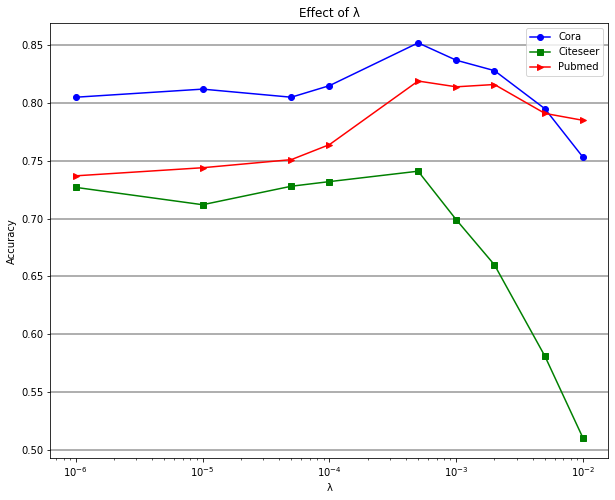

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(lambdas, all_evals[0], color='b', marker='o', label='Cora')
plt.plot(lambdas, all_evals[1], color='g', marker='s', label='Citeseer')
plt.plot(lambdas, all_evals[2], color='r', marker='>', label='Pubmed')
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title("Effect of λ")
plt.grid(axis='y', linestyle='-', linewidth=2)
plt.legend()
plt.xscale("log")

In [36]:

lambdas = [1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
CoraFull_evals = []


for lam in lambdas:
    
  ## default parameters
  hid_dim = 512
  out_dim = 512
  n_layers = 2
  gpu = 0
  epochs = 100
  lr1 = 1e-3
  lr2= 1e-2
  wd1 = 0
  wd2 = 1e-4
  lambd = lam
  use_mlp = False
  der = 0.2
  dfr = 0.2
  
  # check cuda
  if th.cuda.is_available():
      device = 'cuda:{}'.format(gpu)
  else:
      device = 'cpu'

  # if __name__ == '__main__':

  # print(args)
  graph, feat, labels, num_class, train_idx, val_idx, test_idx = load('CoraFull')
  in_dim = feat.shape[1]

  model = CCA_SSG(in_dim, hid_dim, out_dim, n_layers, use_mlp)
  model = model.to(device)

  optimizer = th.optim.Adam(model.parameters(), lr=lr1, weight_decay=wd1)

  N = graph.number_of_nodes()

  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()

      graph1, feat1 = random_aug(graph, feat, dfr, der)
      graph2, feat2 = random_aug(graph, feat, dfr, der)

      graph1 = graph1.add_self_loop()
      graph2 = graph2.add_self_loop()

      graph1 = graph1.to(device)
      graph2 = graph2.to(device)

      feat1 = feat1.to(device)
      feat2 = feat2.to(device)

      z1, z2 = model(graph1, feat1, graph2, feat2)

      c = th.mm(z1.T, z2)
      c1 = th.mm(z1.T, z1)
      c2 = th.mm(z2.T, z2)

      c = c / N
      c1 = c1 / N
      c2 = c2 / N

      loss_inv = -th.diagonal(c).sum()
      iden = th.tensor(np.eye(c.shape[0])).to(device)
      loss_dec1 = (iden - c1).pow(2).sum()
      loss_dec2 = (iden - c2).pow(2).sum()

      loss = loss_inv + lambd * (loss_dec1 + loss_dec2)

      loss.backward()
      optimizer.step()

      #  print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))

  print("=== Evaluation ===")
  graph = graph.to(device)
  graph = graph.remove_self_loop().add_self_loop()
  feat = feat.to(device)

  embeds = model.get_embedding(graph, feat)

  train_embs = embeds[train_idx]
  val_embs = embeds[val_idx]
  test_embs = embeds[test_idx]

  label = labels.to(device)

  train_labels = label[train_idx]
  val_labels = label[val_idx]
  test_labels = label[test_idx]

  train_feat = feat[train_idx]
  val_feat = feat[val_idx]
  test_feat = feat[test_idx]

  ''' Linear Evaluation '''
  logreg = LogReg(train_embs.shape[1], num_class)
  opt = th.optim.Adam(logreg.parameters(), lr=lr2, weight_decay=wd2)

  logreg = logreg.to(device)
  loss_fn = nn.CrossEntropyLoss()

  best_val_acc = 0
  eval_acc = 0

  for epoch in range(2000):
      logreg.train()
      opt.zero_grad()
      logits = logreg(train_embs)
      preds = th.argmax(logits, dim=1)
      train_acc = th.sum(preds == train_labels).float() / train_labels.shape[0]
      loss = loss_fn(logits, train_labels)
      loss.backward()
      opt.step()

      logreg.eval()
      with th.no_grad():
          val_logits = logreg(val_embs)
          test_logits = logreg(test_embs)

          val_preds = th.argmax(val_logits, dim=1)
          test_preds = th.argmax(test_logits, dim=1)

          val_acc = th.sum(val_preds == val_labels).float() / val_labels.shape[0]
          test_acc = th.sum(test_preds == test_labels).float() / test_labels.shape[0]

          if val_acc >= best_val_acc:
              best_val_acc = val_acc
              if test_acc > eval_acc: 
                  eval_acc = test_acc

          # print('Epoch:{}, train_acc:{:.4f}, val_acc:{:4f}, test_acc:{:4f}'.format(epoch, train_acc, val_acc, test_acc))

  print('Linear evaluation accuracy:{:.4f}'.format(eval_acc))
  CoraFull_evals.append(eval_acc) 
  print('Evaluation List of CoraFull dataset :' )
  print(CoraFull_evals)
  print()
# all_evals.append(eval_list)

=== Evaluation ===
Linear evaluation accuracy:0.4962
Evaluation List of CoraFull dataset :
[tensor(0.4962)]

=== Evaluation ===
Linear evaluation accuracy:0.5582
Evaluation List of CoraFull dataset :
[tensor(0.4962), tensor(0.5582)]

=== Evaluation ===
Linear evaluation accuracy:0.6011
Evaluation List of CoraFull dataset :
[tensor(0.4962), tensor(0.5582), tensor(0.6011)]

=== Evaluation ===
Linear evaluation accuracy:0.6073
Evaluation List of CoraFull dataset :
[tensor(0.4962), tensor(0.5582), tensor(0.6011), tensor(0.6073)]

=== Evaluation ===
Linear evaluation accuracy:0.6045
Evaluation List of CoraFull dataset :
[tensor(0.4962), tensor(0.5582), tensor(0.6011), tensor(0.6073), tensor(0.6045)]

=== Evaluation ===
Linear evaluation accuracy:0.5701
Evaluation List of CoraFull dataset :
[tensor(0.4962), tensor(0.5582), tensor(0.6011), tensor(0.6073), tensor(0.6045), tensor(0.5701)]

=== Evaluation ===
Linear evaluation accuracy:0.5405
Evaluation List of CoraFull dataset :
[tensor(0.4962)

In this part, I have chosen the CoraFull dataset to see the effect of different values for the trade-off hyperparameter. The default value has been selected for the other hyperparameters, such as a number of hidden layers, epochs, and regularization term values. It seems that the CoraFull dataset follows the same process of test accuracy by changing $\lambda$ (best selection of $\lambda$ is between 0.0005 to 0.002). Additionally, we can reach higher accuracies for this dataset by adjusting suitable values for the hyperparameters.   

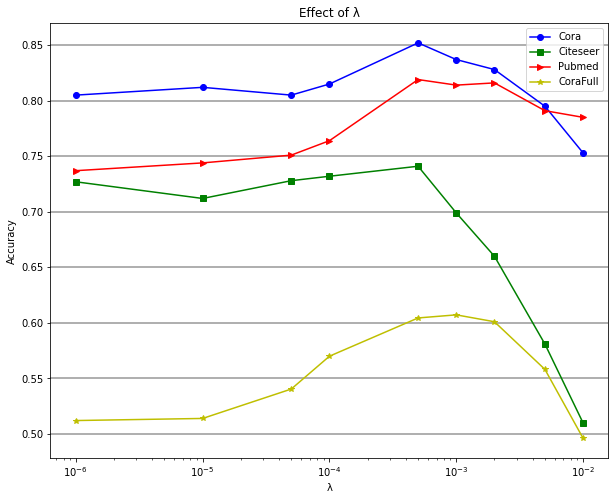

In [41]:
plt.figure(figsize=(10, 8))
plt.plot(lambdas, all_evals[0], color='b', marker='o', label='Cora') 
plt.plot(lambdas, all_evals[1], color='g', marker='s', label='Citeseer') 
plt.plot(lambdas, all_evals[2], color='r', marker='>', label='Pubmed') 
plt.plot(lambdas, CoraFull_evals, color='y', marker='*', label='CoraFull')
plt.xlabel('λ')    
plt.ylabel('Accuracy') 
plt.grid(axis='y', linestyle='-', linewidth=2)
plt.title("Effect of λ")
plt.legend()
plt.xscale("log")